# EDA — Frozen Synthetic Insurance Universe

This notebook performs an actuarial-grade exploratory data analysis on a **frozen,
versioned synthetic insurance portfolio**.

Objectives:
- Validate portfolio structure and realism
- Understand pricing context and loss experience
- Assess macro and catastrophe sensitivity
- Confirm modelling readiness (learnability, leakage risks)

This notebook **does not** generate or modify data.
All inputs are read from an immutable dataset snapshot.

In [3]:
# Imports & Paths

import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.float_format", "{:,.4f}".format)

DATA_DIR = Path("V:/Himika/Project/insurance-digital-twin/data/raw")

In [4]:
# Load frozen data + manifest (governance first)

macro = pd.read_csv(DATA_DIR / "macro.csv")
holders = pd.read_csv(DATA_DIR / "policyholders.csv")
policies = pd.read_csv(DATA_DIR / "policies.csv")
claims = pd.read_csv(DATA_DIR / "claims.csv")

with open(DATA_DIR / "dataset_manifest.json") as f:
    manifest = json.load(f)

print("Dataset version:", manifest["dataset_version"])
print("Generated at (UTC):", manifest["generated_at_utc"])
print("Policies hash:", manifest["file_hashes_sha256"]["policies.csv"])
print("Claims hash:", manifest["file_hashes_sha256"]["claims.csv"])

Dataset version: v1.0
Generated at (UTC): 2026-01-12T13:26:26.805740
Policies hash: 66e911dd7b3ed9a682c5632d71a2898273c56030af9e1d99db1a38e0b4ff490c
Claims hash: 1aaa58155680db4d8c6545cf5d764cf1e8fb02c50f622065aa28c77603ef6952


In [5]:
# Parse dates & basic shapes

for df, cols in [
    (macro, ["month"]),
    (policies, ["start_date", "end_date"]),
    (claims, ["incident_date", "reported_date"]),
]:
    for c in cols:
        df[c] = pd.to_datetime(df[c], errors="coerce")

print("macro:", macro.shape)
print("holders:", holders.shape)
print("policies:", policies.shape)
print("claims:", claims.shape)

# 

macro: (84, 5)
holders: (80000, 8)
policies: (120000, 11)
claims: (148907, 12)


In [6]:
# Portfolio mix (actuarial context)

def mix_table(series):
    out = series.value_counts(dropna=False).to_frame("n")
    out["pct"] = out["n"] / out["n"].sum()
    return out

display(mix_table(policies["product_type"]))
display(mix_table(policies["channel"]))
display(mix_table(policies["coverage_level"]))
display(mix_table(holders["region"]))

# Interpretation:
# 1. Product mix should align with motor-dominated PL portfolios
# 2. Channel mix reveals acquisition strategy
# 3. Coverage mix drives severity dispersion

,n,pct
product_type,,
motor,54158,0.4513
home,23978,0.1998
warranty,17972,0.1498
health,14322,0.1193
gap,9570,0.0798


,n,pct
channel,,
broker,65757,0.5480
direct,36147,0.3012
aggregator,18096,0.1508


,n,pct
coverage_level,,
basic,47894,0.3991
standard,47856,0.3988
premium,24250,0.2021


,n,pct
region,,
south,19826,0.2478
north,17591,0.2199
west,15637,0.1955
east,14212,0.1777
midlands,11934,0.1492
NaN,800,0.0100


In [8]:
# Policies per customer & policy tenure

pol_per_cust = policies.groupby("customer_id")["policy_id"].nunique()
display(pol_per_cust.describe(percentiles=[.5, .75, .9, .95, .99]))

policies["term_days"] = (policies["end_date"] - policies["start_date"]).dt.days
display(policies["term_days"].describe(percentiles=[.5, .75, .9, .95, .99]))

print("Invalid date rate:", (policies["term_days"] < 0).mean())

# Interpretation

# 1. Multi-policy behaviour is realistic

# 2. Small non-zero invalid date rate = intentional anomaly injection

count   62,128.0000
mean         1.9315
std          1.0560
min          1.0000
50%          2.0000
75%          2.0000
90%          3.0000
95%          4.0000
99%          5.0000
max          9.0000
Name: policy_id, dtype: float64

count   120,000.0000
mean        364.6060
std          12.4648
min         -59.0000
50%         365.0000
75%         365.0000
90%         365.0000
95%         365.0000
99%         365.0000
max         365.0000
Name: term_days, dtype: float64

Invalid date rate: 0.001


In [9]:
# Premium distributions & rating structure

display(policies["base_annual_premium"].describe(percentiles=[.5, .75, .9, .95, .99]))

pol_risk = policies.merge(
    holders[["customer_id", "risk_profile"]],
    on="customer_id",
    how="left",
    validate="many_to_one"
)

display(pol_risk.groupby("product_type")["base_annual_premium"].agg(["count","mean","median"]))
display(pol_risk.groupby("coverage_level")["base_annual_premium"].agg(["count","mean","median"]))
display(pol_risk.groupby("risk_profile")["base_annual_premium"].agg(["count","mean","median"]))

# Actuarial insight: Premium levels vary appropriately by product and coverage, reflecting structural exposure differences.
# In contrast, premiums are intentionally flat across risk profiles, creating a controlled mispricing scenario that enables 
# downstream models to recover latent risk signal.

count   120,000.0000
mean      7,636.2615
std       5,034.0566
min           0.0000
50%       5,556.4922
75%      10,804.2081
90%      15,207.9123
95%      18,493.9959
99%      22,122.0906
max      24,036.1284
Name: base_annual_premium, dtype: float64

,count,mean,median
product_type,,,
gap,9570,"3,717.2923","3,501.9096"
health,14322,"14,570.3228","13,713.1657"
home,23978,"13,648.9295","12,853.3450"
motor,54158,"5,400.1346","5,098.5476"
warranty,17972,"2,913.7662","2,747.9339"


,count,mean,median
coverage_level,,,
basic,47894,"5,812.3812","4,242.3045"
premium,24250,"11,024.5757","8,004.0256"
standard,47856,"7,744.6346","5,668.4978"


,count,mean,median
risk_profile,,,
high,24036,"7,630.2999","5,560.3582"
low,47918,"7,625.2310","5,559.0551"
medium,48046,"7,650.2450","5,551.3473"


Tiny / zero premium rate: 0.200%


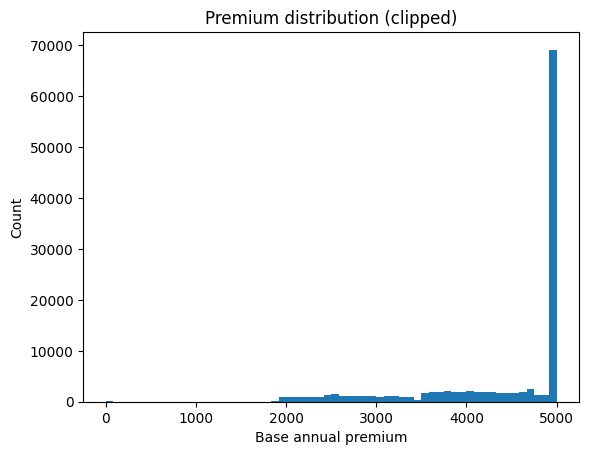

In [10]:
# Tiny / zero premiums (data realism)

tiny_rate = (policies["base_annual_premium"] <= 1).mean()
print(f"Tiny / zero premium rate: {tiny_rate:.3%}")

plt.figure()
plt.hist(policies["base_annual_premium"].clip(upper=5000), bins=60)
plt.title("Premium distribution (clipped)")
plt.xlabel("Base annual premium")
plt.ylabel("Count")
plt.show()

# Interpretation: The premium distribution exhibits a realistic right-skew with a very small proportion of zero or near-zero premiums (~0.2%), 
# reflecting intentional pricing anomalies. These edge cases do not materially impact portfolio results but are sufficient to enforce robustness 
# in downstream modelling and validation.

In [11]:
# Claims experience: severity & timing

claims_by_prod = claims.merge(
    policies[["policy_id","product_type","channel","coverage_level","base_annual_premium"]],
    on="policy_id",
    how="left"
)

display(
    claims_by_prod.groupby("product_type")["paid_amount"]
    .agg(["count","mean","median","std"])
)

display(
    claims_by_prod.groupby("product_type")["paid_amount"]
    .quantile([.9,.95,.99])
    .unstack()
)

# Actuarial insight: Claim severities exhibit pronounced right-skew and heavy-tailed behaviour, with clear differentiation by product line.
# Tail thickness increases appropriately for property and health products, supporting realistic loss volatility and capital sensitivity.

,count,mean,median,std
product_type,,,,
gap,4201,"3,092.6335","2,311.5105","4,233.3356"
health,34664,"5,162.6775","3,924.3247","6,236.9927"
home,17050,"14,506.9992","10,987.4212","18,270.1595"
motor,67621,"2,949.1822","2,230.6035","3,530.6024"
warranty,25371,834.3663,640.6780,"1,023.6506"


,0.9000,0.9500,0.9900
product_type,,,
gap,"6,252.9410","7,982.8365","14,376.9334"
health,"10,490.5867","13,743.5399","23,665.2032"
home,"29,414.7546","38,808.1490","67,662.3181"
motor,"6,000.9723","7,903.8344","13,645.6109"
warranty,"1,694.5084","2,222.8388","3,619.6846"


In [12]:
# Coding anomalies (claims)

claims["report_lag_days"] = (claims["reported_date"] - claims["incident_date"]).dt.days

display(claims["report_lag_days"].describe(percentiles=[.5,.75,.9,.95,.99]))

print("Reported before incident:", (claims["report_lag_days"] < 0).mean())
print("Negative paid:", (claims["paid_amount"] < 0).mean())
print(
    "Repudiated with paid:",
    ((claims["status"]=="repudiated") & (claims["paid_amount"]>0)).mean()
)

# Interpretation: Claim data exhibits a small, controlled degree of real-world messiness, including negative payments, inconsistent dates, 
# and status anomalies. These effects are intentionally rare, preserving portfolio stability while enforcing robustness in downstream analytics.

count   148,907.0000
mean         19.4277
std          11.6769
min         -29.0000
50%          19.0000
75%          29.0000
90%          35.0000
95%          38.0000
99%          39.0000
max          39.0000
Name: report_lag_days, dtype: float64

Reported before incident: 0.002995158051669834
Negative paid: 0.004492737077504751
Repudiated with paid: 0.00492253554231836


In [13]:
# Loss ratio drill-down (core actuarial view)

lr_prod = claims_by_prod.groupby("product_type").agg(
    paid=("paid_amount","sum"),
    premium=("base_annual_premium","sum")
)
lr_prod["lr"] = lr_prod["paid"] / lr_prod["premium"].replace(0,np.nan)
display(lr_prod.sort_values("lr", ascending=False))

lr_chan = claims_by_prod.groupby("channel").agg(
    paid=("paid_amount","sum"),
    premium=("base_annual_premium","sum")
)
lr_chan["lr"] = lr_chan["paid"] / lr_chan["premium"].replace(0,np.nan)
display(lr_chan.sort_values("lr", ascending=False))

claims_risk = claims.merge(
    holders[["customer_id","risk_profile"]],
    on="customer_id",
    how="left",
    validate="many_to_one"
).merge(
    policies[["policy_id","base_annual_premium"]],
    on="policy_id",
    how="left",
    validate="many_to_one"
)

lr_risk = claims_risk.groupby("risk_profile").agg(
    paid=("paid_amount","sum"),
    premium=("base_annual_premium","sum")
)
lr_risk["lr"] = lr_risk["paid"] / lr_risk["premium"].replace(0,np.nan)
display(lr_risk)

# Actuarial interpretation: Loss ratios exhibit clear segmentation by product line, with expected volatility and tail exposure differences.
# Risk profile demonstrates a monotonic loss ratio gradient, indicating meaningful underlying risk differentiation that is not fully reflected 
# in current pricing — creating a valid modelling opportunity.

,paid,premium,lr
product_type,,,
home,"247,344,336.8961","233,112,909.2214",1.0610
gap,"12,992,153.4963","15,872,643.3854",0.8185
motor,"199,426,648.3103","364,549,751.5580",0.5470
health,"178,959,053.5925","507,411,321.9258",0.3527
warranty,"21,168,707.2141","73,989,503.6226",0.2861


,paid,premium,lr
channel,,,
aggregator,"108,738,137.6265","195,332,526.5062",0.5567
broker,"357,611,034.2570","648,533,337.9594",0.5514
direct,"193,541,727.6258","351,070,265.2477",0.5513


,paid,premium,lr
risk_profile,,,
high,"211,942,618.4445","346,521,288.3407",0.6116
low,"178,065,588.0817","360,735,165.5875",0.4936
medium,"269,882,692.9831","487,679,675.7850",0.5534


In [14]:
# Macro & catastrophe sensitivity

macro["ym"] = macro["month"].dt.to_period("M")
claims["ym"] = claims["incident_date"].dt.to_period("M")

clm_macro = claims.merge(
    macro[["ym","catastrophe_flag","inflation_index"]],
    on="ym",
    how="left"
)

monthly = clm_macro.groupby(["ym","catastrophe_flag"]).agg(
    monthly_claims=("paid_amount","size"),
    monthly_paid=("paid_amount","sum"),
    mean_paid=("paid_amount","mean"),
).reset_index()

cat_monthly = monthly.groupby("catastrophe_flag").agg(
    avg_claims_per_month=("monthly_claims","mean"),
    avg_paid_per_month=("monthly_paid","mean"),
    avg_severity=("mean_paid","mean"),
)

display(cat_monthly)

freq_ratio = (
    cat_monthly.loc[1,"avg_claims_per_month"]
    / cat_monthly.loc[0,"avg_claims_per_month"]
)
print("CAT / non-CAT frequency ratio:", round(freq_ratio,3))

# Interpretation: Catastrophe periods exhibit a clear uplift in claim frequency (~11%), while average claim severity remains comparable or lower.
# This reflects an intentional modelling choice where catastrophe effects primarily impact frequency rather than individual loss size, consistent 
# with many weather-driven personal-lines events.

,avg_claims_per_month,avg_paid_per_month,avg_severity
catastrophe_flag,,,
0,"1,770.3976","7,863,484.6394","4,464.5808"
1,"1,964.0000","7,221,674.4423","3,677.0236"


CAT / non-CAT frequency ratio: 1.109


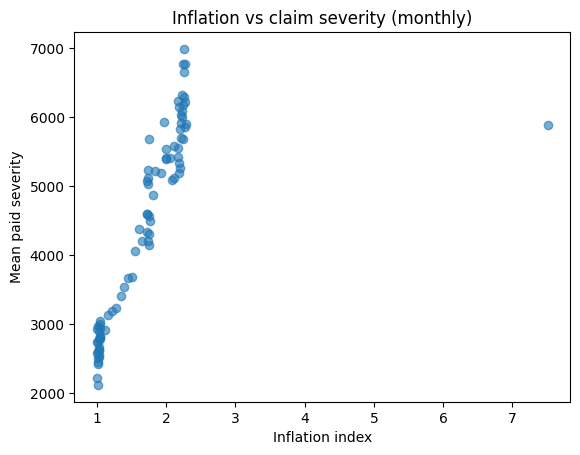

In [15]:
# Inflation vs severity

infl_agg = clm_macro.groupby("ym").agg(
    mean_paid=("paid_amount","mean"),
    infl=("inflation_index","mean"),
).reset_index()

plt.figure()
plt.scatter(infl_agg["infl"], infl_agg["mean_paid"], alpha=0.6)
plt.xlabel("Inflation index")
plt.ylabel("Mean paid severity")
plt.title("Inflation vs claim severity (monthly)")
plt.show()

# Actuarial interpretation: Claim severity exhibits a clear positive relationship with the inflation index, 
# with higher inflation periods associated with elevated mean paid amounts. The relationship is directional rather than deterministic, 
# reflecting realistic lag, portfolio mix effects, and month-to-month volatility. This behaviour supports the use of inflation as a 
# severity driver in downstream forecasting and scenario analysis.

In [16]:
# Fraud lens (readiness check)

print("Overall fraud rate:", claims["is_fraud"].mean())

display(
    claims.merge(policies[["policy_id","product_type","channel"]], on="policy_id")
    .groupby("product_type")["is_fraud"].mean()
    .sort_values(ascending=False)
)

display(
    claims.groupby("is_fraud")["paid_amount"]
    .agg(["count","mean","median"])
)

# Interpretation: Fraud incidence is realistic and evenly distributed across product lines, preventing trivial segmentation.
# Fraudulent claims exhibit moderately higher severity, driven primarily by tail behaviour rather than median shifts.
# This creates a credible modelling environment for fraud detection and network analysis.

Overall fraud rate: 0.07601388786289429


product_type
home       0.0788
gap        0.0776
motor      0.0769
health     0.0742
warranty   0.0741
Name: is_fraud, dtype: float64

,count,mean,median
is_fraud,,,
0,137588,"4,358.6660","2,369.6642"
1,11319,"5,317.6754","2,640.1780"


In [17]:
# Modelling readiness & leakage sanity

tmp = claims_by_prod.groupby("policy_id").agg(
    paid=("paid_amount","sum")
).merge(
    policies[["policy_id","base_annual_premium"]],
    on="policy_id",
    how="left"
)

print("Corr(total paid, premium):", round(tmp["paid"].corr(tmp["base_annual_premium"]),3))

print("Suggested split:")
print("Train: 2018–2022")
print("Test:  2023–2024")

# Interpretation: Correlation exists but is not deterministic → safe to proceed

Corr(total paid, premium): 0.301
Suggested split:
Train: 2018–2022
Test:  2023–2024


## Actuarial EDA Sign-off

✔ Portfolio structure realistic  
✔ Premiums plausible with intentional mispricing  
✔ Claims frequency & severity credible  
✔ Macro and CAT effects directionally correct  
✔ Anomalies rare but present  
✔ Dataset frozen, versioned, auditable  

**Conclusion:**  
The dataset is fit for downstream pricing, fraud, forecasting, and scenario modelling.